# BOOM BIKES CASE STUDY

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands.

#### Business Goal:
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

In [1]:
#Importing the required libraries and packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statistics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

In [2]:
#Setting some options
pd.set_option("max_rows",None)
pd.set_option("max_columns",None)

In [3]:
#Importing the Dataset
df=pd.read_csv("day.csv",index_col=0)

## Data Inspection

In [4]:
#Inspecting the Dataset
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Data description
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [5]:
#Checking the dataset shape
df.shape

(730, 15)

In [6]:
#Checking the Datatypes of the columns and checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


Thus there are no missing values in the dataset as all the columns are non-null.

## Data Preprocessing

### Data Preparation and Creating Metrics

In [7]:
#Changing the Datatype of dteday from object to date
df.dteday=pd.to_datetime(df.dteday,yearfirst=True,dayfirst=True)

In [8]:
#Changing the season datatype to category and changing the labels.(1:spring, 2:summer, 3:fall, 4:winter)
def season(x):
    if x==1:
        return "Spring"
    elif x==2:
        return "Summer"
    elif x==3:
        return "Fall"
    else:
        return "Winter"
df["season"]=df["season"].apply(season)

In [9]:
#Changing the month datatype to category and changing the labels.
df["mnth"]=df.dteday.dt.month_name()

In [10]:
#Changing the weekday datatype to category 
df["weekday"]=df.dteday.dt.day_name()

In [11]:
#Changing the weathersit datatye to category and changing the labels. : 
#1: Clear, Few clouds, Partly cloudy, Partly cloudy
#2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
def weather(x):
    if x==1:
        return "Clear"
    elif x==2:
        return "Mist"
    elif x==3:
        return "Light Rain"
    else:
        return "Heavy Rain"
df["weathersit"]=df["weathersit"].apply(weather)

In [12]:
#Checking the correlation between atem and temp
df.temp.corr(df.atemp)

0.991696178690565

In [13]:
#The correlation between these two columns are as high as 0.99. Let's see which of these columns are more correlated
#to cnt variable
print("Correlation b/w cnt and temp: ",df.temp.corr(df.cnt))
print("Correlation b/w cnt and atemp: ",df.atemp.corr(df.cnt))

Correlation b/w cnt and temp:  0.6270440344135153
Correlation b/w cnt and atemp:  0.6306853489531039


Here atemp has very slightly high correlation coeff with the cnt variable, and hence we'll delete the temp variable as keeping both the variable make no sense. We will not delete any variable right away but our model will not include both the variables together.

As for registered and casual variable, we will not remove these variables right away as they can be usefull in analysis but they cannot be included in the model with cnt as the response variable. I will also make another columns that show the ratio of Casual users with respect to the total users. This might help us in the Exploratory Data Analysis.

In [14]:
#Making two more columns casual_ratio
df["casual_ratio"]=df["casual"]/df["cnt"]

In [15]:
#Checking the head of the data
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,casual_ratio
instant,,,,,,,,,,,,,,,,
1,2018-01-01,Spring,0,January,0,Monday,1,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985,0.336041
2,2018-01-02,Spring,0,January,0,Tuesday,1,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801,0.163546
3,2018-01-03,Spring,0,January,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0.088955
4,2018-01-04,Spring,0,January,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0.069142
5,2018-01-05,Spring,0,January,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0.051250


In [16]:
#Renaming some column names to make the analysis easier
df=df.rename(columns={"yr":"year","mnth":"month","hum":"humidity","cnt":"count"})

In [17]:
#MAKING DUMMY VARIABLES FOR COLUMNS:- season,mnth,weekday,weathersit
dummies=pd.get_dummies(df[["season","month","weekday","weathersit"]],drop_first=True)

#Concatinating the dummies dataset to the original dataset and give that dataset a name of df1
df1=pd.concat([df,dummies],axis=1)
df1=df1.drop(["season","month","weekday","weathersit","casual","registered","casual_ratio"],axis=1)

In [18]:
df1.head()

,dteday,year,holiday,workingday,temp,atemp,humidity,windspeed,count,season_Spring,season_Summer,season_Winter,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Rain,weathersit_Mist
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2018-01-01,0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2018-01-02,0,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,2018-01-03,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2018-01-04,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,2018-01-05,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


df would be used for EDA and df1 will be used for the model fitting as it has dummy variables and not categorical variables.

### Checking for outliers

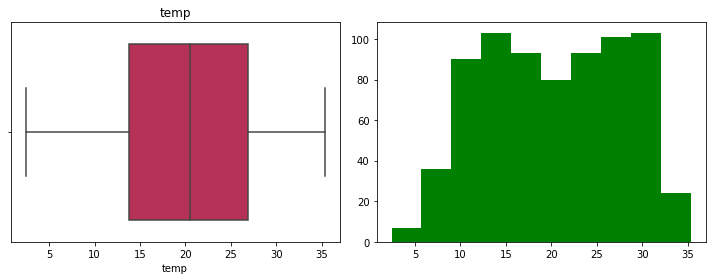

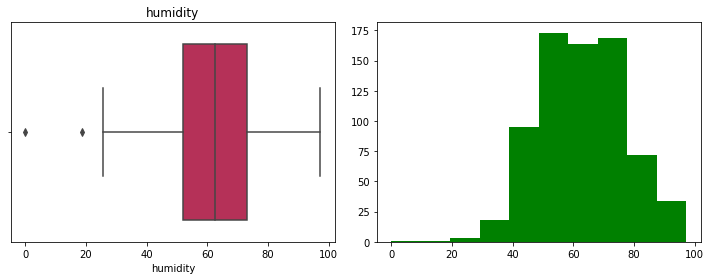

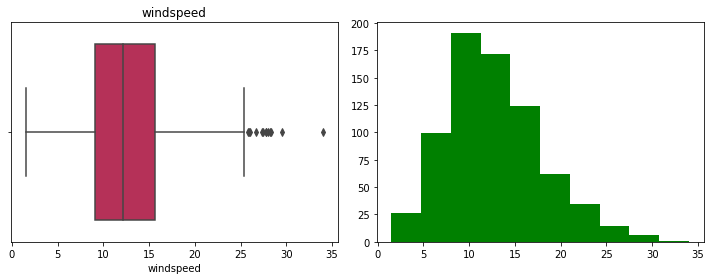

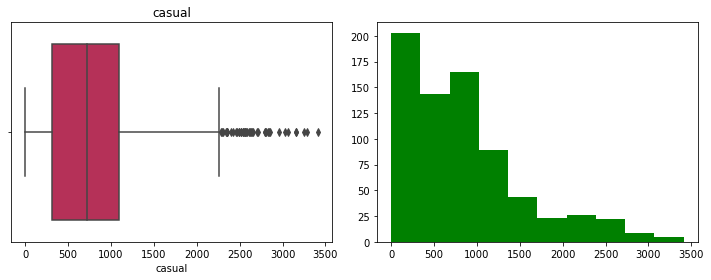

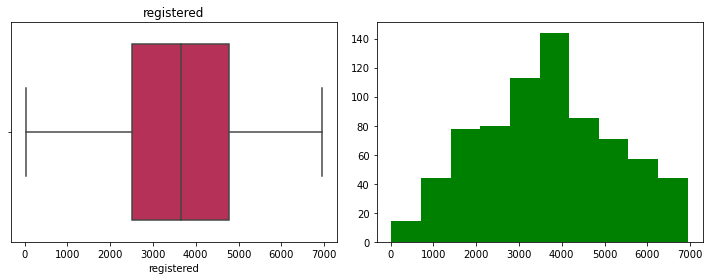

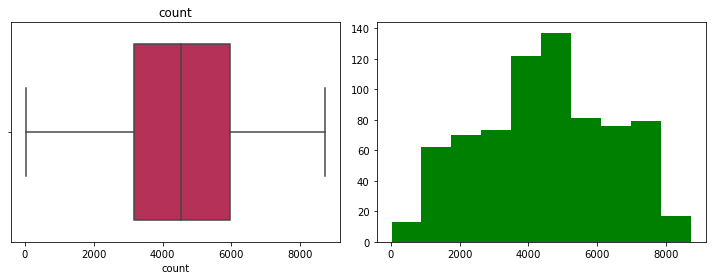

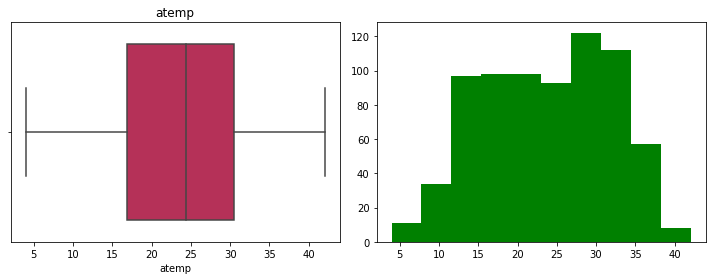

In [19]:
#Checking for outliers in the continuous variables temp,humidity, windspeed,casual,registered,count
cont=['temp','humidity', 'windspeed','casual','registered','count',"atemp"]
for i in cont:
    plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    sns.boxplot(df[i],palette="rocket")
    plt.title(i)
    plt.subplot(1,2,2)
    plt.hist(df[i],color="g")
    plt.tight_layout()
    plt.show()
 

In [20]:
df[cont].describe()

,temp,humidity,windspeed,casual,registered,count,atemp
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,62.765175,12.763620,849.249315,3658.757534,4508.006849,23.726322
std,7.506729,14.237589,5.195841,686.479875,1559.758728,1936.011647,8.150308
min,2.424346,0.000000,1.500244,2.000000,20.000000,22.000000,3.953480
25%,13.811885,52.000000,9.041650,316.250000,2502.250000,3169.750000,16.889713
50%,20.465826,62.625000,12.125325,717.000000,3664.500000,4548.500000,24.368225
75%,26.880615,72.989575,15.625589,1096.500000,4783.250000,5966.000000,30.445775
max,35.328347,97.250000,34.000021,3410.000000,6946.000000,8714.000000,42.044800


Thus we see from above results, the data doesn't seem to have any major outliers as shown in the histogram and the outliers. Also as the mean and median for all the variables seem to be almost coinciding and hence the data is good enough to proceed with the analysis.

## Exploratory Data Analysis

### Univariate Data Analysis

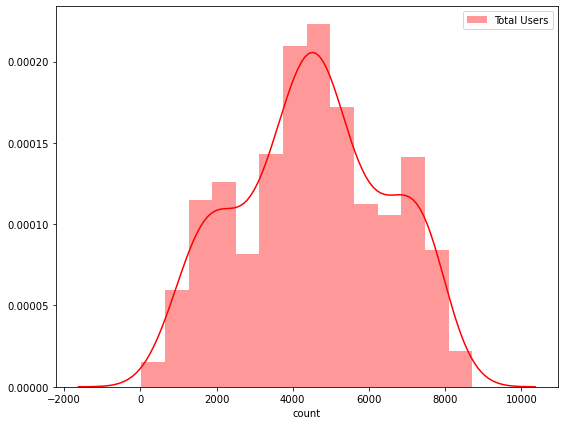

In [21]:
#Looking at the distribution of the target variable count
plt.figure(figsize=[9,7])
sns.distplot(df["count"],color="r",label="Total Users")
plt.legend()
plt.show()

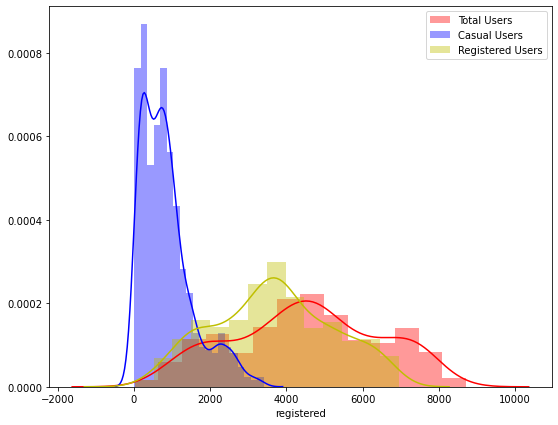

In [22]:
#Comparing the distribution of Target Variable with Casual and Registered
plt.figure(figsize=[9,7])
sns.distplot(df["count"],color="r",label="Total Users")
sns.distplot(df["casual"],color="b",label="Casual Users")
sns.distplot(df["registered"],color="y",label="Registered Users")
plt.legend()
plt.show()

Thus we see that the distribtution of Total users is very similar to that of Registered users and hence it can be said that the total users constituted more of the registered users and less of casual users.

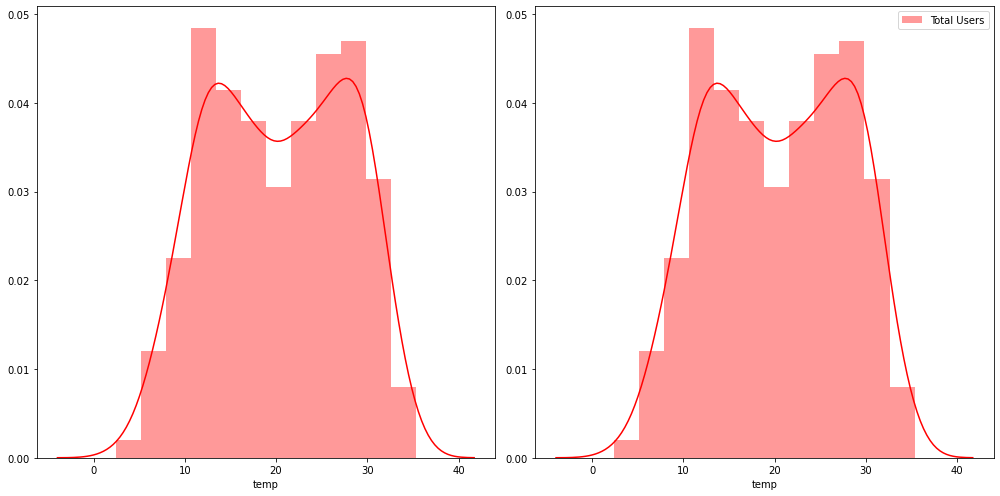

In [23]:
plt.figure(figsize=[14,7])
plt.subplot(1,2,1)
sns.distplot(df["temp"],color="r",label="Total Users")
plt.subplot(1,2,2)
sns.distplot(df["temp"],color="r",label="Total Users")
plt.legend()
plt.tight_layout()
plt.show()

### Bivariate analysis of the count variable with other categorical variables 

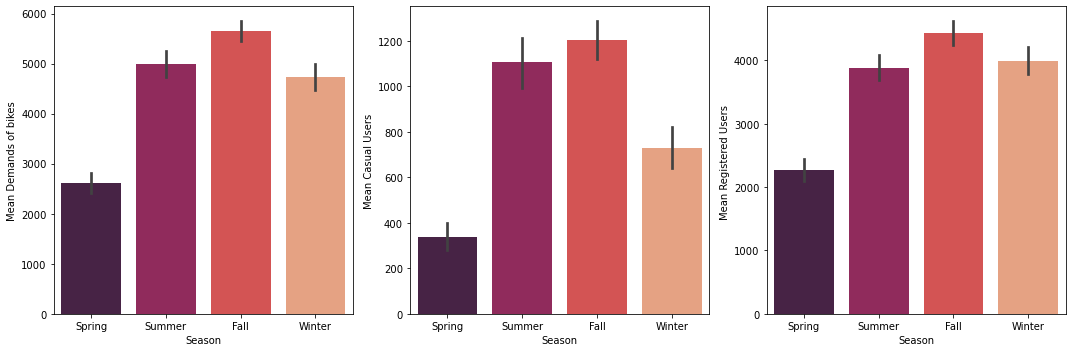

In [24]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
sns.barplot('season','count',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Demands of bikes")
plt.xlabel("Season")
plt.subplot(1,3,2)
sns.barplot('season','casual',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Casual Users")
plt.xlabel("Season")
plt.subplot(1,3,3)
sns.barplot('season','registered',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Registered Users ")
plt.xlabel("Season")
plt.tight_layout()
plt.show()


We see from the graphs that the demand for bikes is highest in fall and very low in Spring.

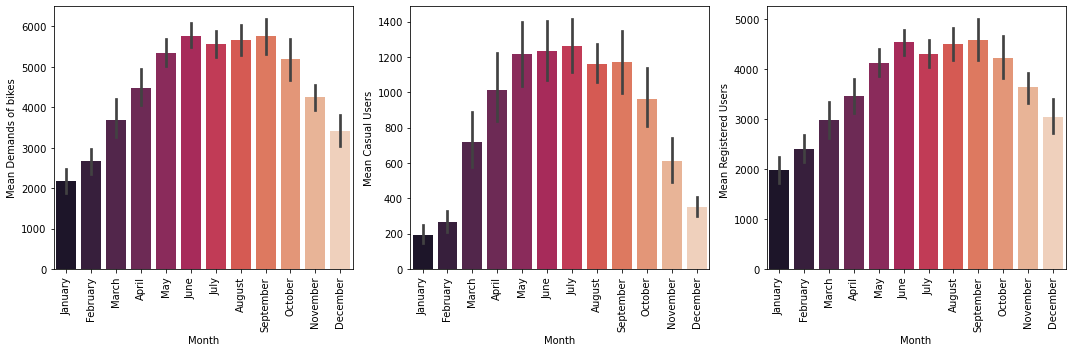

In [25]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
sns.barplot('month','count',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Demands of bikes")
plt.xlabel("Month")
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.barplot('month','casual',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Casual Users")
plt.xlabel("Month")
plt.xticks(rotation=90)
plt.subplot(1,3,3)
sns.barplot('month','registered',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Registered Users ")
plt.xlabel("Month")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

It can be seen from the graphs that in average, the most demand of bikes in the months May, June, July, August, September (summer and fall months) and least in January, February. The trent is same for casual and registered bikes.

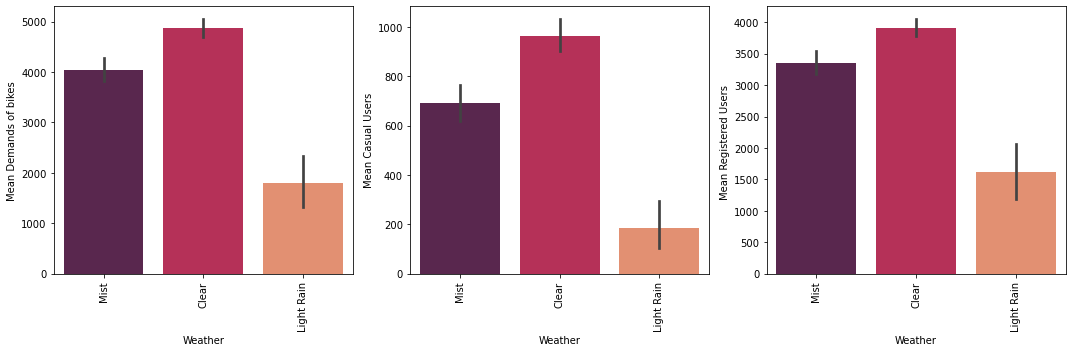

In [26]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
sns.barplot('weathersit','count',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Demands of bikes")
plt.xlabel("Weather")
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.barplot('weathersit','casual',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Casual Users")
plt.xlabel("Weather")
plt.xticks(rotation=90)
plt.subplot(1,3,3)
sns.barplot('weathersit','registered',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Registered Users ")
plt.xlabel("Weather")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

It is seen that the highest number of bikes are rented when the weather is clear. It's also interesting to notice that there are no bikes rented when the rain is heavy (there is no bar for heavy rain)

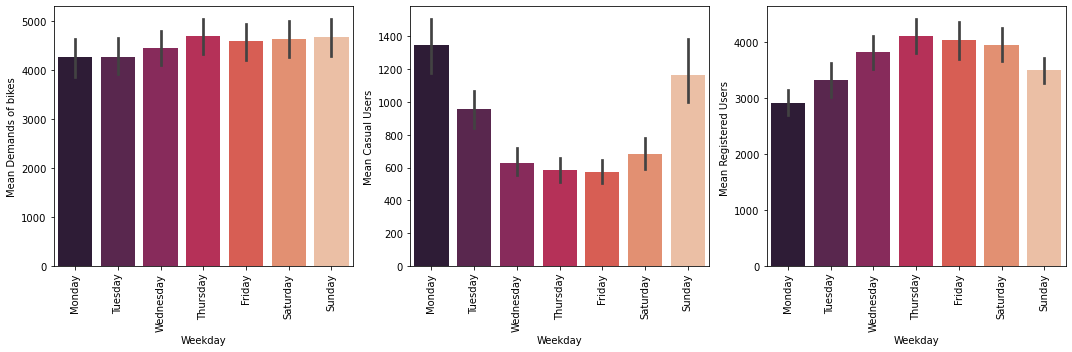

In [27]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
sns.barplot('weekday','count',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Demands of bikes")
plt.xlabel("Weekday")
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.barplot('weekday','casual',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Casual Users")
plt.xlabel("Weekday")
plt.xticks(rotation=90)
plt.subplot(1,3,3)
sns.barplot('weekday','registered',data=df,palette="rocket",estimator=statistics.mean)
plt.ylabel("Mean Registered Users ")
plt.xlabel("Weekday")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here, we see that trend for Casual users is different compared to the registered users as the casual users are more likely to rent the bike on Monday and Sunday whereas a registered user is more likely to rent a bike on Thursday.

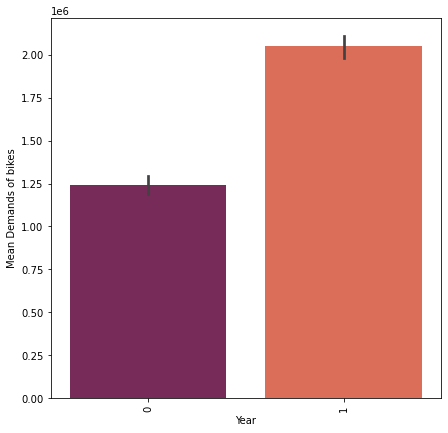

In [28]:
plt.figure(figsize=[7,7])
sns.barplot('year','count',data=df,palette="rocket",estimator=sum)
plt.ylabel("Mean Demands of bikes")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.show()

As wee see, the demands of bikes went significantly high from 2018 to 2019

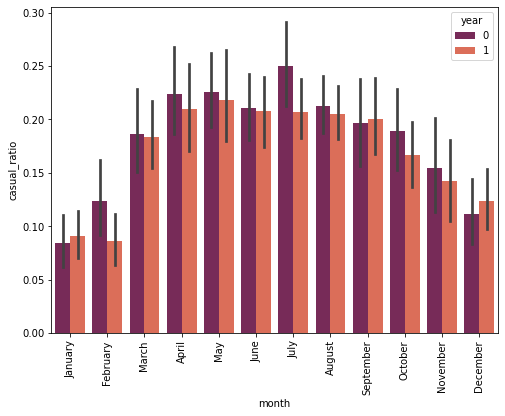

In [29]:
plt.figure(figsize=[8,6])
plt.xticks(rotation=90)
sns.barplot('month','casual_ratio',data=df,palette="rocket",estimator=statistics.mean,hue="year")
plt.show()

There isn't much of a difference between the ratio of casual users between 2018 and 2019. The same can be visualized using Boxplots.

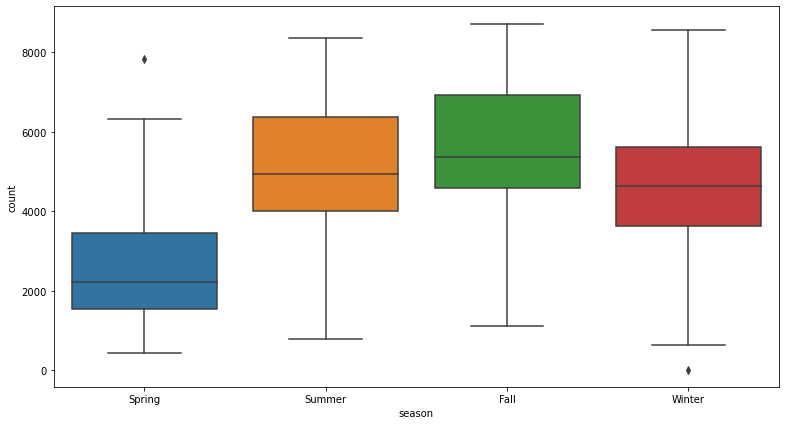

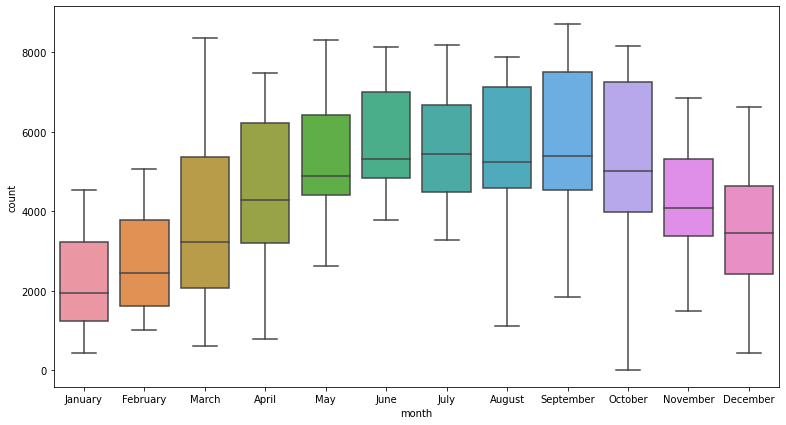

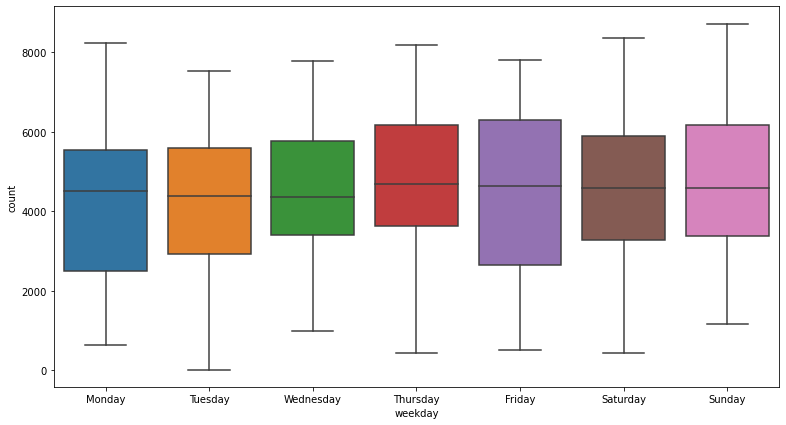

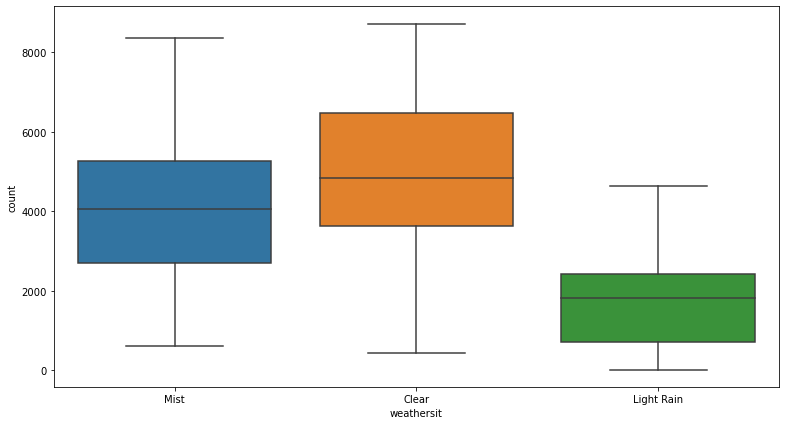

In [30]:
category=list(df.select_dtypes("object").columns)
for i in category:
    plt.figure(figsize=[13,7])
    sns.boxplot(y="count",x=i,data=df)
    plt.show()
    

It can be seen from the graphs that:
    - Spring has very less number of rented bikes
    - The bike renting becomes more frequent in May, June, July.
    - There isn't much of a difference b/w the what day it is wrt to renting of bikes
    - People rent more bike when the weather is clear

### Bivariate analysis on continuous variables

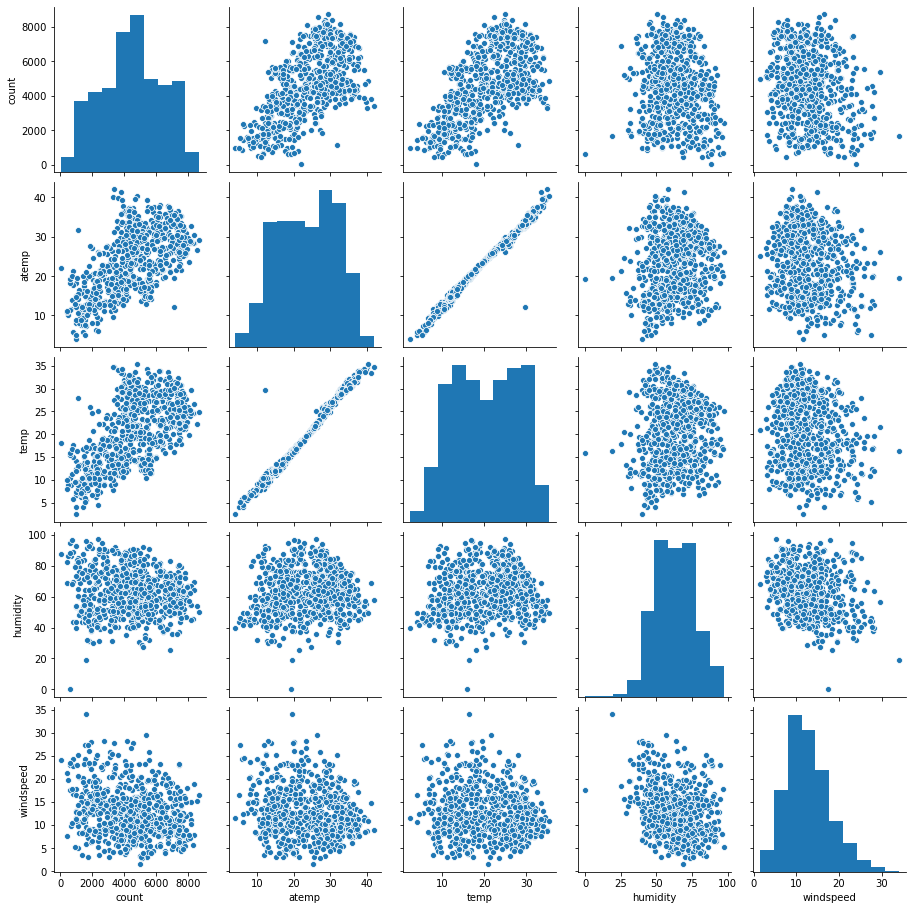

In [31]:
numerical= ['count',"atemp",'temp','humidity','windspeed']
sns.pairplot(df[numerical])
plt.show()

By analysing all the plots above, we can see that there are some independent variables look positively correlated to the 'count' variable.

- Bike rentals are more correlated to a-temperature.
- Bike rentals more at high humidity.
Looking it at more clearly:

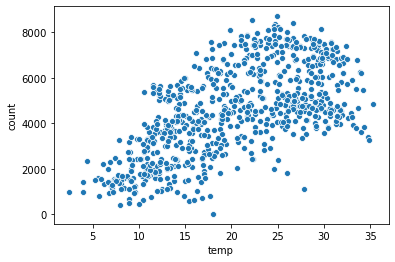

In [32]:
sns.scatterplot(x='temp',y='count' ,data=df)
plt.show()

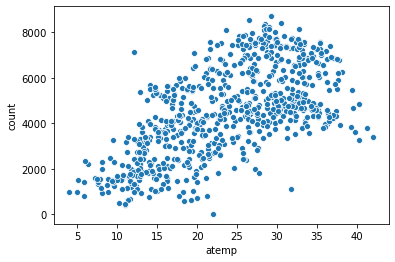

In [33]:
sns.scatterplot(x='atemp',y='count' ,data=df)
plt.show()

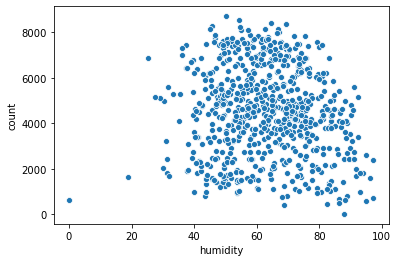

In [34]:
sns.scatterplot(x='humidity', y='count',data=df)
plt.show()

Checking the correlation between the different variables from Df dataset and from df1 dataset.

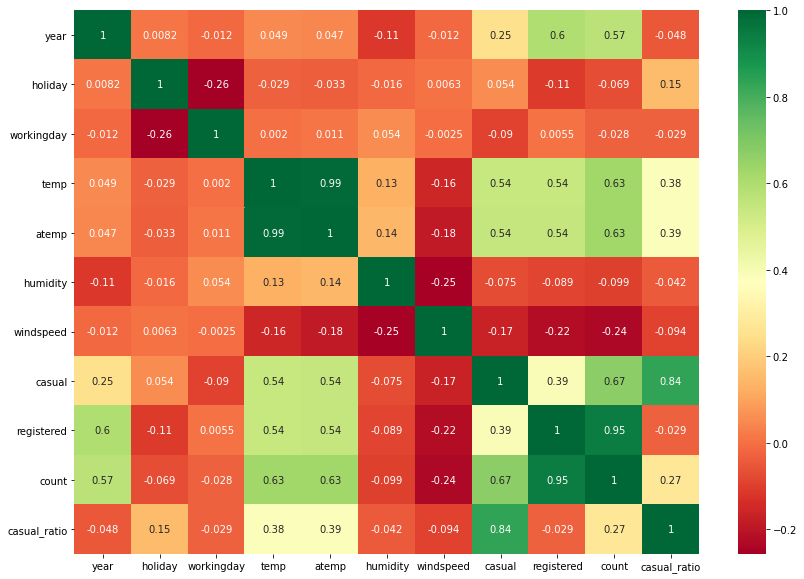

In [35]:
plt.figure(figsize=[14,10])
sns.heatmap(df.corr(),cmap='RdYlGn',annot=True)
plt.show()

In [36]:
df1.corr()["count"].sort_values(ascending=False)

count                    1.000000
atemp                    0.630685
temp                     0.627044
year                     0.569728
month_June               0.195568
month_September          0.194664
month_August             0.182100
month_July               0.166236
season_Summer            0.145325
month_May                0.132553
month_October            0.108846
season_Winter            0.064619
weekday_Thursday         0.038672
weekday_Sunday           0.033227
weekday_Saturday         0.025004
weekday_Wednesday       -0.013282
workingday              -0.027640
month_November          -0.040344
weekday_Tuesday         -0.049471
weekday_Monday          -0.052581
holiday                 -0.068764
humidity                -0.098543
month_March             -0.128456
weathersit_Mist         -0.170686
month_December          -0.173878
windspeed               -0.235132
weathersit_Light Rain   -0.240602
month_February          -0.273848
month_January           -0.367167
season_Spring 

Now that we have an overview of the data, we will go ahead and split the data.

### Splitting the Data into Training and Testing Sets

In [37]:
np.random.seed(1)
df_train,df_test=train_test_split(df1,test_size=0.3,random_state=100)

In [38]:
df_train.shape

(511, 31)

In [39]:
df_test.shape

(219, 31)

### Rescaling the Features 

We are going to use min max scaling for the continuous variables (except count, casual and registered)

In [40]:
scaler=MinMaxScaler()

In [41]:
cont=["temp","humidity","windspeed",'count',"atemp"]

In [42]:
df_train[cont]=scaler.fit_transform(df_train[cont])

In [43]:
df_train.head()

,dteday,year,holiday,workingday,temp,atemp,humidity,windspeed,count,season_Spring,season_Summer,season_Winter,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Rain,weathersit_Mist
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
654,2019-10-16,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
577,2019-07-31,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
427,2019-03-03,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
729,2019-12-30,1,0,1,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
483,2019-04-28,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [44]:
df_train=df_train.drop(["dteday"],axis=1)

In [45]:
df_train.shape

(511, 30)

As the number of features are 30, we will first use RFE to get the top 16 variables and then use manual selection to reach to the best model.

In [46]:
y_train=df_train.pop("count")

### Building a model using temp

In [47]:
X_train=df_train.drop(["atemp"],axis=1)
lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(lm,16)
rfe = rfe.fit(X_train, y_train)

In [48]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 2),
 ('temp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('month_August', False, 8),
 ('month_December', True, 1),
 ('month_February', True, 1),
 ('month_January', True, 1),
 ('month_July', True, 1),
 ('month_June', False, 11),
 ('month_March', False, 13),
 ('month_May', False, 7),
 ('month_November', True, 1),
 ('month_October', False, 10),
 ('month_September', True, 1),
 ('weekday_Monday', False, 6),
 ('weekday_Saturday', False, 3),
 ('weekday_Sunday', False, 4),
 ('weekday_Thursday', False, 12),
 ('weekday_Tuesday', False, 5),
 ('weekday_Wednesday', False, 9),
 ('weathersit_Light Rain', True, 1),
 ('weathersit_Mist', True, 1)]

In [49]:
col = X_train.columns[rfe.support_]
col

Index(['year', 'holiday', 'temp', 'humidity', 'windspeed', 'season_Spring',
       'season_Summer', 'season_Winter', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_November', 'month_September',
       'weathersit_Light Rain', 'weathersit_Mist'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [50]:
X_train=sm.add_constant(df_train[col])
model1=sm.OLS(y_train,X_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     169.6
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          7.96e-189
Time:                        10:37:57   Log-Likelihood:                 516.26
No. Observations:                 511   AIC:                            -998.5
Df Residuals:                     494   BIC:                            -926.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3324      0.037      9.051      0.000       0.260       0.405
year                      0.2312      0.008     28.629      0.000       0.215       0.247
holiday                  -0.0887      0.026     -3.462      0.001      -0.139      -0.038
temp                      0.4648      0.038     12.161      0.000       0.390       0.540
humidity                 -0.1607      0.038     -4.255      0.000      -0.235      -0.087
windspeed                -0.1900      0.026     -7.371      0.000      -0.241      -0.139
season_Spring            -0.0515      0.022     -2.337      0.020      -0.095      -0.008
season_Summer             0.0387      0.015      2.508      0.012       0.008       0.069
season_Winter             0.1019      0.018      5.667      0.000       0.067       0.137
month_December           -0.0463      0.018     -2.526      0.012      -0.082      -0.010
month_February           -0.0360      0.022     -1.661      0.097      -0.079       0.007
month_January            -0.0630      0.022     -2.928      0.004      -0.105      -0.021
month_July               -0.0545      0.018     -2.988      0.003      -0.090      -0.019
month_November           -0.0457      0.019     -2.410      0.016      -0.083      -0.008
month_September           0.0734      0.017      4.345      0.000       0.040       0.107
weathersit_Light Rain    -0.2486      0.026     -9.417      0.000      -0.300      -0.197
weathersit_Mist          -0.0549      0.010     -5.260      0.000      -0.075      -0.034
==============================================================================
Omnibus:                       71.820   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.486
Skew:                          -0.728   Prob(JB):                     1.29e-38
Kurtosis:                       5.464   Cond. No.                         21.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,85.83
6,season_Spring,5.69
3,temp,4.72
8,season_Winter,3.84
7,season_Summer,2.82
11,month_January,2.37
4,humidity,1.93
10,month_February,1.86
13,month_November,1.80
9,month_December,1.65


As we see in the model that month february has a high p value and hence is insignificant. Also, through the vif table, we see that only spring season has the vif slightly greater than 5. We will first drop the Month february and check the statistics.

In [52]:
X_train=X_train.drop(["month_February"],axis=1)
model2=sm.OLS(y_train,X_train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     180.1
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          2.29e-189
Time:                        10:37:57   Log-Likelihood:                 514.84
No. Observations:                 511   AIC:                            -997.7
Df Residuals:                     495   BIC:                            -929.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3206      0.036      8.882      0.000       0.250       0.392
year                      0.2308      0.008     28.543      0.000       0.215       0.247
holiday                  -0.0912      0.026     -3.558      0.000      -0.142      -0.041
temp                      0.4809      0.037     12.982      0.000       0.408       0.554
humidity                 -0.1628      0.038     -4.305      0.000      -0.237      -0.089
windspeed                -0.1888      0.026     -7.314      0.000      -0.240      -0.138
season_Spring            -0.0614      0.021     -2.888      0.004      -0.103      -0.020
season_Summer             0.0421      0.015      2.742      0.006       0.012       0.072
season_Winter             0.1037      0.018      5.767      0.000       0.068       0.139
month_December           -0.0370      0.017     -2.117      0.035      -0.071      -0.003
month_January            -0.0437      0.018     -2.408      0.016      -0.079      -0.008
month_July               -0.0555      0.018     -3.039      0.002      -0.091      -0.020
month_November           -0.0408      0.019     -2.177      0.030      -0.078      -0.004
month_September           0.0749      0.017      4.434      0.000       0.042       0.108
weathersit_Light Rain    -0.2471      0.026     -9.351      0.000      -0.299      -0.195
weathersit_Mist          -0.0546      0.010     -5.223      0.000      -0.075      -0.034
==============================================================================
Omnibus:                       67.308   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.984
Skew:                          -0.686   Prob(JB):                     4.06e-36
Kurtosis:                       5.402   Cond. No.                         20.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,82.64
6,season_Spring,5.27
3,temp,4.42
8,season_Winter,3.83
7,season_Summer,2.77
4,humidity,1.92
12,month_November,1.76
10,month_January,1.68
15,weathersit_Mist,1.57
9,month_December,1.49


The fall in R^2 isn't significant and also we see that vif value of Spring has decreased a bit. Also, December is no isignificant and hence we will drop it.

In [54]:
X_train=X_train.drop(["month_December"],axis=1)
model3=sm.OLS(y_train,X_train).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     191.3
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          1.49e-189
Time:                        10:37:57   Log-Likelihood:                 512.54
No. Observations:                 511   AIC:                            -995.1
Df Residuals:                     496   BIC:                            -931.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3035      0.035      8.597      0.000       0.234       0.373
year                      0.2306      0.008     28.420      0.000       0.215       0.247
holiday                  -0.0921      0.026     -3.584      0.000      -0.143      -0.042
temp                      0.5060      0.035     14.369      0.000       0.437       0.575
humidity                 -0.1708      0.038     -4.521      0.000      -0.245      -0.097
windspeed                -0.1858      0.026     -7.181      0.000      -0.237      -0.135
season_Spring            -0.0561      0.021     -2.648      0.008      -0.098      -0.014
season_Summer             0.0479      0.015      3.162      0.002       0.018       0.078
season_Winter             0.0989      0.018      5.525      0.000       0.064       0.134
month_January            -0.0339      0.018     -1.927      0.055      -0.069       0.001
month_July               -0.0562      0.018     -3.069      0.002      -0.092      -0.020
month_November           -0.0253      0.017     -1.459      0.145      -0.059       0.009
month_September           0.0798      0.017      4.749      0.000       0.047       0.113
weathersit_Light Rain    -0.2408      0.026     -9.139      0.000      -0.293      -0.189
weathersit_Mist          -0.0531      0.010     -5.070      0.000      -0.074      -0.033
==============================================================================
Omnibus:                       60.899   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.145
Skew:                          -0.643   Prob(JB):                     6.09e-31
Kurtosis:                       5.210   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,78.50
6,season_Spring,5.20
3,temp,3.97
8,season_Winter,3.77
7,season_Summer,2.68
4,humidity,1.90
9,month_January,1.57
14,weathersit_Mist,1.56
10,month_July,1.49
11,month_November,1.48


Dropping variable november due to it's insignificance.

In [56]:
X_train=X_train.drop(["month_November"],axis=1)
model4=sm.OLS(y_train,X_train).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.4
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          2.94e-190
Time:                        10:37:58   Log-Likelihood:                 511.44
No. Observations:                 511   AIC:                            -994.9
Df Residuals:                     497   BIC:                            -935.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2962      0.035      8.466      0.000       0.227       0.365
year                      0.2306      0.008     28.383      0.000       0.215       0.247
holiday                  -0.0968      0.026     -3.787      0.000      -0.147      -0.047
temp                      0.5135      0.035     14.720      0.000       0.445       0.582
humidity                 -0.1691      0.038     -4.474      0.000      -0.243      -0.095
windspeed                -0.1875      0.026     -7.246      0.000      -0.238      -0.137
season_Spring            -0.0515      0.021     -2.456      0.014      -0.093      -0.010
season_Summer             0.0503      0.015      3.341      0.001       0.021       0.080
season_Winter             0.0934      0.018      5.331      0.000       0.059       0.128
month_January            -0.0331      0.018     -1.879      0.061      -0.068       0.002
month_July               -0.0559      0.018     -3.049      0.002      -0.092      -0.020
month_September           0.0825      0.017      4.934      0.000       0.050       0.115
weathersit_Light Rain    -0.2396      0.026     -9.087      0.000      -0.291      -0.188
weathersit_Mist          -0.0529      0.010     -5.047      0.000      -0.073      -0.032
==============================================================================
Omnibus:                       58.698   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.688
Skew:                          -0.627   Prob(JB):                     2.54e-29
Kurtosis:                       5.148   Cond. No.                         19.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,76.91
6,season_Spring,5.09
3,temp,3.89
8,season_Winter,3.60
7,season_Summer,2.65
4,humidity,1.90
9,month_January,1.57
13,weathersit_Mist,1.56
10,month_July,1.49
11,month_September,1.30


January is now insignificant and hence we'll drop it as well.

In [58]:
X_train=X_train.drop(["month_January"],axis=1)
model5=sm.OLS(y_train,X_train).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     221.1
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          1.12e-190
Time:                        10:37:58   Log-Likelihood:                 509.63
No. Observations:                 511   AIC:                            -993.3
Df Residuals:                     498   BIC:                            -938.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2846      0.035      8.244      0.000       0.217       0.352
year                      0.2298      0.008     28.253      0.000       0.214       0.246
holiday                  -0.0973      0.026     -3.801      0.000      -0.148      -0.047
temp                      0.5308      0.034     15.739      0.000       0.465       0.597
humidity                 -0.1736      0.038     -4.590      0.000      -0.248      -0.099
windspeed                -0.1823      0.026     -7.069      0.000      -0.233      -0.132
season_Spring            -0.0560      0.021     -2.679      0.008      -0.097      -0.015
season_Summer             0.0532      0.015      3.539      0.000       0.024       0.083
season_Winter             0.0990      0.017      5.726      0.000       0.065       0.133
month_July               -0.0575      0.018     -3.133      0.002      -0.094      -0.021
month_September           0.0831      0.017      4.955      0.000       0.050       0.116
weathersit_Light Rain    -0.2373      0.026     -8.987      0.000      -0.289      -0.185
weathersit_Mist          -0.0529      0.011     -5.039      0.000      -0.074      -0.032
==============================================================================
Omnibus:                       57.563   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.018
Skew:                          -0.613   Prob(JB):                     5.85e-29
Kurtosis:                       5.145   Cond. No.                         19.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,74.52
6,season_Spring,5.02
3,temp,3.61
8,season_Winter,3.49
7,season_Summer,2.62
4,humidity,1.89
12,weathersit_Mist,1.56
9,month_July,1.48
10,month_September,1.30
11,weathersit_Light Rain,1.24


As we see that the model seems to be appropriate, the VIF value of spring is 5.02 which is very slightly higher than 5 and isn't a very crucial concern and hence we'll retain the variable. This seems to be the best for the target variable. 

The model 5 seems to be a good fit when we are using temp. Let's try to build the same model (model 5) with atemp and see which model is a better fit.

In [60]:
X_train.columns

Index(['const', 'year', 'holiday', 'temp', 'humidity', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'month_July',
       'month_September', 'weathersit_Light Rain', 'weathersit_Mist'],
      dtype='object')

In [61]:
X_train=sm.add_constant(df_train[['year', 'holiday', 'atemp', 'humidity', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'month_July',
       'month_September', 'weathersit_Light Rain', 'weathersit_Mist']])
model6=sm.OLS(y_train,X_train).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     213.9
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          1.07e-187
Time:                        10:37:58   Log-Likelihood:                 502.56
No. Observations:                 511   AIC:                            -979.1
Df Residuals:                     498   BIC:                            -924.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3081      0.034      8.942      0.000       0.240       0.376
year                      0.2313      0.008     28.073      0.000       0.215       0.248
holiday                  -0.0936      0.026     -3.605      0.000      -0.145      -0.043
atemp                     0.5274      0.035     15.078      0.000       0.459       0.596
humidity                 -0.1715      0.038     -4.468      0.000      -0.247      -0.096
windspeed                -0.1627      0.026     -6.220      0.000      -0.214      -0.111
season_Spring            -0.0815      0.020     -4.016      0.000      -0.121      -0.042
season_Summer             0.0352      0.015      2.371      0.018       0.006       0.064
season_Winter             0.0749      0.017      4.475      0.000       0.042       0.108
month_July               -0.0598      0.019     -3.205      0.001      -0.096      -0.023
month_September           0.0783      0.017      4.609      0.000       0.045       0.112
weathersit_Light Rain    -0.2333      0.027     -8.698      0.000      -0.286      -0.181
weathersit_Mist          -0.0538      0.011     -5.052      0.000      -0.075      -0.033
==============================================================================
Omnibus:                       56.749   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.874
Skew:                          -0.551   Prob(JB):                     1.73e-33
Kurtosis:                       5.423   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Clearly model 5 is a better fit compared to model 6. And hence we will proceed with model 5 and do a residual analysis. 

## Residual analysis on the train data

In [62]:
X_train=sm.add_constant(df_train[[ 'year', 'holiday', 'temp', 'humidity', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'month_July',
       'month_September', 'weathersit_Light Rain', 'weathersit_Mist']])
y_train_pred=model5.predict(X_train)

In [63]:
residual=y_train-y_train_pred

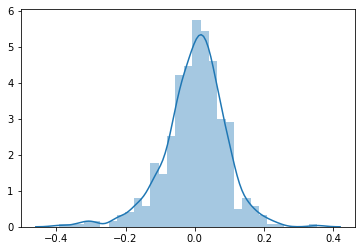

In [64]:
sns.distplot(residual)
plt.show()

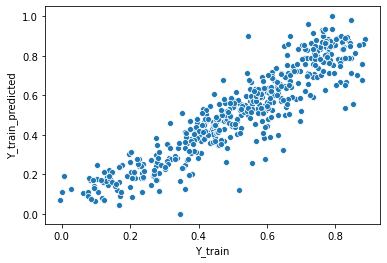

In [65]:
sns.scatterplot(y_train_pred,y_train)
plt.xlabel("Y_train")
plt.ylabel("Y_train_predicted")
plt.show()

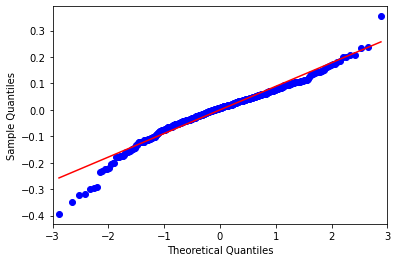

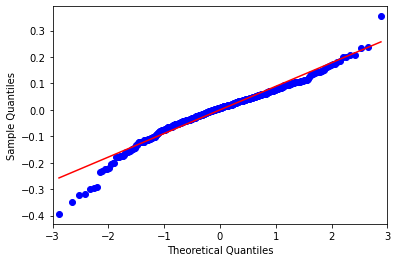

In [66]:
sm.qqplot(residual,line='s')

In [67]:
r2_score(y_train,y_train_pred)

0.8419622043443404

# Prediction and Model Evaluation

In [68]:
df_test[cont]=scaler.transform(df_test[cont])

In [69]:
y_test=df_test.pop("count")
X_test=sm.add_constant(df_test[['year', 'holiday', 'temp', 'humidity', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'month_July',
       'month_September', 'weathersit_Light Rain', 'weathersit_Mist']])

In [70]:
y_pred=model5.predict(X_test)

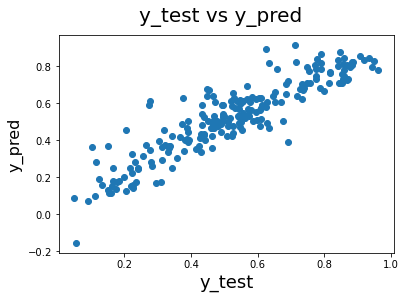

In [71]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                          
plt.ylabel('y_pred', fontsize = 16)  
plt.show()

In [72]:
r2=r2_score(y_test,y_pred)
print(r2)

0.8147844417912915


In [73]:
n=X_test.shape[0]
p=X_test.shape[1]
adjusted_r2=1-(1-r2)*(n-1)/(n-p-1)

In [74]:
print(adjusted_r2)

0.8030390649292758


# Conclusions

- Train R^2 : 0.841
- Train Adjusted R^2 : 0.838
- Test R^2: 0.815
- Test Adjusted R^2=0.803
- Difference in R^2 between train and test: 3% 
- Difference between train Adj R^2 and test Adj R^2: 3%






# Inferences

- We arrived at a very decent model for the the demand for shared bikes with the significant variables with almost 82% of the variability in Count explained by the model.


- We can see that temperature variable is has the highest coefficient 0.5308, which means if the temperature increases by one unit the number of bike rentals increases by 0.4914 units, which also explains that the demand for bike rental is maximum in the summer.


- Another point to notice is that the holiday variable as a negative coefficient, and thus it implies that there are more bike rentals on working days compared to holidays.


- Also, we saw in data there were no bike rentals in heavy rain at all. Also, Light rain and mist have a negative coefficient with the bike rentals, meaning clear season must have the highest number of bike rentals.


- Spring has a negative coefficient, while summer and winters have positive coeffiecients.


## Business Goals:

- A US bike-sharing provider BoomBikes should focus more on Temperature.


- They should give coupons in Spring, Mist, Rain. 


- As we see that there was a high increase in the bike rentals from 2018-2019, the company should continue using the marketing strategy they use in 2019, with more efforts and force.


- Can focus more on Summer & Winter season, August, September month, Weekends, Working days as they have good influence on bike rentals.
